# DataBlock API foundations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_07a import *

In [3]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160'

## Image ItemList

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

### Get Images

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/jupyter/.fastai/data/imagenette2-160')

To be able to look at what's inside a directory from a notebook, we add the `.ls` method to `Path` with a monkey-patch.

In [5]:
#export
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())# adding ls property to Path object

In [6]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val')]

In [7]:
(path/'val').ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n03000684'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n03425413'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n03888257'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n03394916'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n03417042'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n02102040'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n03445777'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n03028079'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n02979186')]

Let's have a look inside a class folder (the first class is tench):

In [8]:
path_tench = path/'val'/ 'n01440764'

In [9]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764/n01440764_9861.JPEG')

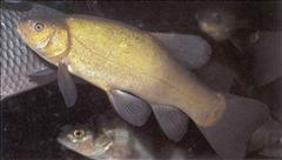

In [10]:
img = PIL.Image.open(img_fn)
img

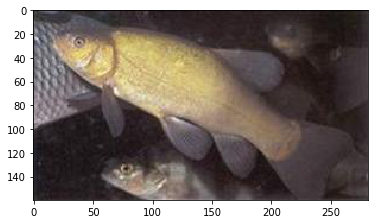

In [11]:
plt.imshow(img)

In [12]:
# just to see what an img contains
import numpy
imga = numpy.array(img)

In [13]:
imga.shape

(160, 282, 3)

In [14]:
imga[:10, :10, 0]

array([[ 28,  46,  48,  46, ...,  95,  97,  89,  92],
       [ 46,  65,  64,  54, ...,  84,  89,  91,  95],
       [ 49,  69,  70,  57, ...,  64,  68,  71,  74],
       [ 41,  61,  65,  56, ...,  54,  55,  46,  48],
       ...,
       [ 53,  63,  61,  56, ...,  51,  55,  65,  65],
       [ 40,  61,  72,  73, ...,  45,  46,  54,  56],
       [ 75,  84,  65,  63, ...,  60,  48,  57,  58],
       [ 94, 104,  83,  76, ...,  84,  79,  71,  65]], dtype=uint8)

Which is ints ranging from 0 to 255

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

In [15]:
mimetypes.types_map.items()

dict_items([('.a', 'application/octet-stream'), ('.ai', 'application/postscript'), ('.aif', 'audio/x-aiff'), ('.aifc', 'audio/x-aiff'), ('.aiff', 'audio/x-aiff'), ('.au', 'audio/basic'), ('.avi', 'video/x-msvideo'), ('.bat', 'text/plain'), ('.bcpio', 'application/x-bcpio'), ('.bin', 'application/octet-stream'), ('.bmp', 'image/bmp'), ('.c', 'text/plain'), ('.cdf', 'application/x-netcdf'), ('.cpio', 'application/x-cpio'), ('.csh', 'application/x-csh'), ('.css', 'text/css'), ('.csv', 'text/csv'), ('.dll', 'application/octet-stream'), ('.doc', 'application/msword'), ('.dot', 'application/msword'), ('.dvi', 'application/x-dvi'), ('.eml', 'message/rfc822'), ('.eps', 'application/postscript'), ('.etx', 'text/x-setext'), ('.exe', 'application/octet-stream'), ('.gif', 'image/gif'), ('.gtar', 'application/x-gtar'), ('.h', 'text/plain'), ('.hdf', 'application/x-hdf'), ('.htm', 'text/html'), ('.html', 'text/html'), ('.ico', 'image/vnd.microsoft.icon'), ('.ief', 'image/ief'), ('.jpe', 'image/jpeg'

In [16]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [17]:
''.join(image_extensions)

'.jpe.pnm.xbm.ppm.tiff.xpm.tif.pgm.gif.xwd.jpg.ico.ief.rgb.jpeg.ras.svg.bmp.png.pbm'

In [18]:
#export
def setify(o): return o if isinstance(o, set) else set(listify(o))

In [19]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa', 1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

In [20]:
#export
def _get_files(p, fs, extensions=None):# p is parent directory and fs is our list of files.
    p = Path(p)# if it's not a path object already then this converts it into one.
    res = [p/f for f in fs if not f.startswith('.')
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)] # don't include the extensions the coder didn't ask for OR include the ones he did ask for.
    return res

In [21]:
path_tench

PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764')

In [22]:
x = [o.name for o in os.scandir(path_tench)]; x[:5]

['n01440764_9861.JPEG',
 'n01440764_6380.JPEG',
 'n01440764_9720.JPEG',
 'n01440764_6642.JPEG',
 'n01440764_12571.JPEG']

In [23]:
t = [o.name for o in os.scandir(path_tench)] # grabs just the filenames
t = _get_files(path_tench, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764/n01440764_9861.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764/n01440764_6380.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764/n01440764_9720.JPEG')]

That was just for one folder so we can put all of this together like down below:

In [24]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)):# returns (dirpath, dirnames, filenames) see below
            if include is not None and i==0: d[:] = [o for o in d if o in include]# if include != None this changes the list of direcotries you can look at.
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else: 
        f = [o.name for o in os.scandir(path) if o.is_file()]# returns just the filenames in present directory(NOT folders!)
        return _get_files(path, f, extensions)                

So get_files goes down the chain directory and once it is at the lowest level, _get_files runs through them and stores the path of all files

In [25]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764/n01440764_9861.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764/n01440764_6380.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/val/n01440764/n01440764_9720.JPEG')]

We need the recurse argument when we start from `path` since the pictures are two level below in directories.

In [26]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_27164.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16817.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_9978.JPEG')]

In [27]:
for i,(p,d,f) in enumerate(os.walk(path)):
#     pdf- dirpath, dirname, filenames
    print(i,p,d,f)
    if i==3: break

0 /home/jupyter/.fastai/data/imagenette2-160 ['train', 'val'] []
1 /home/jupyter/.fastai/data/imagenette2-160/train ['n03000684', 'n03425413', 'n03888257', 'n03394916', 'n03417042', 'n02102040', 'n03445777', 'n01440764', 'n03028079', 'n02979186'] []
2 /home/jupyter/.fastai/data/imagenette2-160/train/n03000684 [] ['n03000684_27164.JPEG', 'n03000684_16817.JPEG', 'n03000684_9978.JPEG', 'n03000684_16379.JPEG', 'n03000684_20985.JPEG', 'n03000684_23424.JPEG', 'n03000684_11228.JPEG', 'n03000684_14977.JPEG', 'n03000684_5587.JPEG', 'n03000684_337.JPEG', 'n03000684_26377.JPEG', 'n03000684_6728.JPEG', 'n03000684_14184.JPEG', 'n03000684_5279.JPEG', 'n03000684_18438.JPEG', 'n03000684_33547.JPEG', 'n03000684_35223.JPEG', 'n03000684_24435.JPEG', 'n03000684_26865.JPEG', 'n03000684_33094.JPEG', 'n03000684_4666.JPEG', 'ILSVRC2012_val_00017719.JPEG', 'n03000684_12878.JPEG', 'n03000684_8103.JPEG', 'n03000684_16406.JPEG', 'n03000684_8864.JPEG', 'n03000684_16506.JPEG', 'n03000684_4557.JPEG', 'n03000684_1964

In [28]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Imagenet is 100 times bigger than imagenette, so we need this to be fast.

In [29]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

62.1 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modelling

What we need to do:  
  
- Get files
- Split validation set  (need the grandparent)
    - random%, foldername, csv...
- Label: (need the parent)
    - folder name, filename/re, csv, ...
- Transform per image(optional)
- Transform to tensor
- DataLoader
- Transform per batch(optional)
- DataBunch
- Add test set(optional)

### Get files

We use the `ListContainer` class from nb 06  to store our objects in an ItemList. The `_get` method will need to be subclassed to explain how to access an element(open an image for instance), then the private `_get` method can allow us to apply any additional transforms to it.  
  
`new` will be used in conjunction with `__getitem__`(that works for one index or a list of indexes) to create training and validation set from a single stream when we split the data.

In [30]:
#export
# https://www.geeksforgeeks.org/function-composition-in-python/
def compose(x, funcs, *args, order_key = '_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    # items are your list of files
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms
    
    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    # creates a new itemlist of the same type, same path and same transforms but with new items(having class as ImageList here.) 
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def __getitem__(self, idx): # called when you index into your ItemList
        res = super().__getitem__(idx) # returns either a single item or a list of items
        if isinstance(res, list): return [self._get(o) for o in res]
        return self._get(res)
    
    def _get(self, i): return compose(self.get(i), self.tfms)# modify the img by applying all present transformations
    def get(self, i): return i
    
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms aren't only used for data augmentation. To allow total flexibiliy, `ImageList` returns the raw PIL image. So if image is a grayscale then PIL only returns two axes and not the third(channel axis) which would cause to dataset function to break. Thus,the first thing is to convert it to 'RGB'(or something else).  
  
Transforms only need to be functions that take an element of the `ItemList` and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an `_order` attribute(default 0) that is used to sort the transforms.

In [31]:
#export
class Transform(): _order= 0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')
    
# OR
def make_rgb(item): return item.convert('RGB')

In [32]:
il = ImageList.from_files(path, tfms=make_rgb)
il

ImageList (13394 items)
[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_27164.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16817.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_9978.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16379.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_20985.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_23424.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_11228.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_14977.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_5587.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_337.JPEG')...]
Path: /home/jupyter/.fastai/data/ima

In [33]:
# same but now the transform is a class
il = ImageList.from_files(path, tfms=MakeRGB())
il

ImageList (13394 items)
[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_27164.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16817.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_9978.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16379.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_20985.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_23424.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_11228.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_14977.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_5587.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_337.JPEG')...]
Path: /home/jupyter/.fastai/data/ima

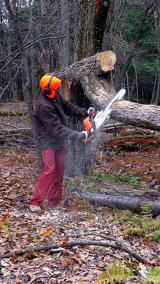

In [34]:
img = il[0]; img

We can also index with a range or a list of integers

In [35]:
il[:2]

[<PIL.Image.Image image mode=RGB size=160x284 at 0x7F7FB0282550>,
 <PIL.Image.Image image mode=RGB size=180x160 at 0x7F7FB0282190>]

### Split Validation set

Here, we need to split the files between those in the folder train and those in the folder val.

In [36]:
fn = il.items[0]; fn

PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_27164.JPEG')

Since our filenames are `path` object, we can find the directory of the file with `.parent`. We need to go back two folders before since the last folders are the class names.

In [37]:
fn.parent.parent.name

'train'

In [38]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # None values will be filtered out
    f = [o for o,m in zip(items, mask) if m==False]
    t = [o for o,m in zip(items, mask) if m==True]
    return f,t

In [39]:
splitter = partial(grandparent_splitter, valid_name='val')
%time train, valid = split_by_func(il, splitter)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.1 ms


In [40]:
len(train), len(valid)

(9469, 3925)

In [41]:
train[:5]

[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_27164.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16817.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_9978.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16379.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_20985.JPEG')]

Now that we can split our data, let's create the class that will contain it. It just needs two `ItemList` to be initialized, & we create a shortcut to all unknown attributes by trying to grab them in the `train` `ItemList`

In [42]:
#export
class SplitData():
    def __init__(self, train, valid): self.train, self.valid= train, valid
    
    # if you pass SplitData some attribute it doesn't know about, it'll grab it from the training set.
    def __getattr__(self, k): return getattr(self.train, k)
    
    # this is needed if we want to pickle SplitData and be able to upload it without any recursion errors
    def __setstate__(self, data:Any): self.__dict__.update(data) #**
    
    
    # we want split_by_func to return the itemlist of the same type that we gave(imagelist in this case)
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f)) ##
        return cls(*lists)
    
    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [43]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (9469 items)
[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_27164.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16817.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_9978.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16379.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_20985.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_23424.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_11228.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_14977.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_5587.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_337.JPEG')...]
Path: /home/jupyter/

### Labelling

Labelling has to be done after splitting, because it uses training set info to apply to the validation set, using a Processor.  
  
A Processor is a transformation that is applied to all the inputs once at initialization, with some state computed on the training set that is then applied without modification on the validation set(and maybe the test set or at inference time or a single item). For instance, it could be **processing texts to tokenize**, then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.  
  
Another example is **tabular data** where we fill missing values with the medians(for instance) computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.  
  
In our case, we want to convert label strings to numbers in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this vocab.

In [44]:
#export
from collections import OrderedDict

# gives all possible unique names in a list
def uniqueify(x, sort=False):
    res=  list(OrderedDict.fromkeys(x).keys())
    if sort: sort(res)
    return res

First let's define our Processor. We also define a `ProcessedItemList` with an `obj` method that can get the unprocessed items: for instance a processed label with an index between 0 and no of classes-1, the corresponding `obj` will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [45]:
#export
class Processor():
    def process(self, items): return items
    
# create a list of all the possible categories.
class CategoryProcessor(Processor):
    def __init__(self): self.vocab= None
        
    def __call__(self, items):
        # the vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            #otoi- object to int
            self.otoi = {v:k for k,v in enumerate(self.vocab)}
        #process the items one at a time
        return [self.proc1(o) for o in items]
    
    def proc1(self, item): return self.otoi[item]
    
    # for printing out class names during inference
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx)  for idx in idxs]
    
    def deproc1(self, idx): return self.vocab[idx]

Here we label according to the folders of the images, so simply `fn.parent.name` will suffice. We label the training set with a newly created `CategoryProcessor` so that it computes its inner `vocab` on that set. Then we label the validation set using the same processor, which means that it uses the same `vocab`. The end result is another `SplitData` object.

In [46]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

class LabeledData(): ##slightly different; lesson 12
    def process(self, il, proc): return il.new(compose(il.items, proc))
    
    def __init__(self, x, y, proc_x = None, proc_y=None):
        self.x, self.y = self.process(x, proc_x), self.process(y, proc_y)
        self.proc_x, self.proc_y = proc_x, proc_y
    
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self, idx): return self.x[idx], self.y[idx]
    def __len__(self): return len(self.x)
    
    ##
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item
    
    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x= proc_x, proc_y= proc_y)
    
    
def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train, valid)

In [47]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [48]:
assert ll.train.proc_y is ll.valid.proc_y

In [49]:
ll.train.y

ItemList (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /home/jupyter/.fastai/data/imagenette2-160

In [50]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03000684', ['n03000684', 'n03000684'])

In [51]:
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_27164.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16817.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_9978.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_16379.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_20985.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_23424.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_11228.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_14977.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_5587.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette2-160/train/n03000684/n03000684_337.JPEG')...]
Path:

### Transform to tensor

In [52]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=160x284 at 0x7F8003FDD810>, 0)

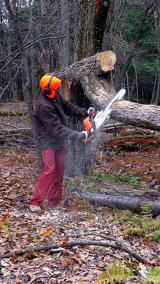

In [53]:
ll.train[0][0]

To be able to put all our images in a batch, we need them to have all the same size. We can do this easily in PIL.

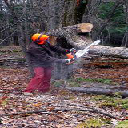

In [54]:
ll.train[0][0].resize((128,128))

The first transform resizes to a given size, then we convert the image to a byte tensor before converting it to float and dividing by 255. We will investigate data augmentations transforms at length in nb10

In [55]:
#export 
class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size, int): size = (size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)
    

# After turning all images into same size, we can then convert them into tensor.    
def to_byte_tensor(item):
    # converting pillow obj into a tensor
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(h,w,-1).permute(2,0,1)# pillow has channel last whereas pytorch expects channels first
to_byte_tensor._order= 20

# we now have a byte tensor but we actually need a float tensor
def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [56]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [57]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    # to print them out we have to put the channel last again
    plt.imshow(im.permute(1,2,0))

In [58]:
x, y = ll.train[0]
x.shape, y

(torch.Size([3, 128, 128]), 0)

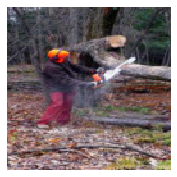

In [59]:
show_image(x)

## Modeling

## DataBunch

In [60]:
bs=64
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [61]:
x, y = next(iter(train_dl))

In [62]:
x.shape

torch.Size([64, 3, 128, 128])

We can still see the images in a batch and get the corresponding classes.

'n03425413'

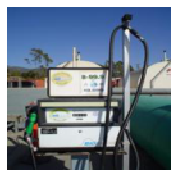

In [63]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [64]:
y, y.shape

(tensor([1, 7, 6, 3, 8, 8, 6, 0, 2, 6, 3, 6, 1, 9, 3, 5, 8, 6, 0, 2, 9, 5, 6, 9,
         5, 5, 6, 0, 7, 5, 7, 5, 2, 6, 8, 3, 1, 5, 7, 1, 8, 7, 1, 4, 8, 5, 5, 5,
         4, 9, 4, 9, 7, 9, 1, 2, 0, 3, 7, 6, 9, 0, 2, 6]), torch.Size([64]))

We change a little bit our DataBunch to add a few attributes like c_in(channels_in) and c_out(channels_out) instead of just `c`. This will help when we need to build our model.

In [65]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl, valid_dl, c_in, c_out
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset

Then we define a function that goes directly from the `SplitData` to a `DataBunch`

In [66]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

This gives us the full summary on how to grab our data and put it in a `DataBunch`.

In [67]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

### Model

In [68]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback]

In [69]:
# three channel mean and std
m, s = x.mean((0,2,3)).cuda(), x.std((0,2,3)).cuda()
m,s

(tensor([0.4529, 0.4486, 0.4201], device='cuda:0'),
 tensor([0.2637, 0.2612, 0.2901], device='cuda:0'))

In [70]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None])/ std[..., None,None]

_m = tensor([0.50, 0.48, 0.48])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [71]:
norm_imagenette

functools.partial(<function normalize_chan at 0x7f7fa9f46680>, mean=tensor([0.5000, 0.4800, 0.4800], device='cuda:0'), std=tensor([0.2900, 0.2800, 0.3000], device='cuda:0'))

In [72]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [73]:
nfs = [64,64,128,256]

We build our model using [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187), in particular: we don't use a big conv 7x7 at first but three 3x3 convs, and don't go directly from 3 channels to 64 but progressively add those.  
Because large kernel sizes(5x5 or 7x7) initially is not a good idea. A 3x3 kernels give you more bang for your buck. You get deeper, end up w the same receptive field and its faster because of less computations.

In [74]:
#export
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)# =16 if l1=3channels
    layers = [f(l1  , l2  , stride=1),
             f(l2   , l2*2, stride=1),
             f(l2*2 , l2*4, stride=2)]
    nfs = [l2*4]+nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
              nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [75]:
prev_pow_2(27)

16

In [76]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1, 0.3, 0.05))

In [77]:
learn, run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
  partial(ParamScheduler, 'lr', sched)  
])

Let's have a look at our model using Hooks. We print the layers and the shapes of their outputs.

In [78]:
#export

#very useful
def model_summary(run, learn, data, find_all=False):
    xb, yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device # model may not be on the gpu yet
    xb, yb = xb.to(device), yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook, mod, inp, out: print(f'{mod}\n{out.shape}\n')
    with Hooks(mods, f) as hooks: learn.model(xb)

In [79]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 128, 128])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 64, 64])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size

In [81]:
learn.opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.2
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [83]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

And we can train the model:

In [82]:
%time run.fit(5, learn)

train: [1.8087465924992079, tensor(0.3741, device='cuda:0')]
valid: [1.776416077826433, tensor(0.4087, device='cuda:0')]
train: [1.4514785913243216, tensor(0.5115, device='cuda:0')]
valid: [1.5143753732085987, tensor(0.4986, device='cuda:0')]
train: [1.1293122830090294, tensor(0.6259, device='cuda:0')]
valid: [1.1110944964171974, tensor(0.6497, device='cuda:0')]
train: [0.8409790851231651, tensor(0.7303, device='cuda:0')]
valid: [1.0096113654458598, tensor(0.6782, device='cuda:0')]
train: [0.6397011382537755, tensor(0.8062, device='cuda:0')]
valid: [0.9630542147691082, tensor(0.6991, device='cuda:0')]
CPU times: user 28 s, sys: 8.26 s, total: 36.2 s
Wall time: 41.6 s


The [leaderboard](https://github.com/fastai/imagenette/blob/master/README.md) as this notebook is written has ~85% accuracy for 5 epochs at 128px size, so we're definitely on the right track!

## Export

In [95]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
